0.06032265807021718


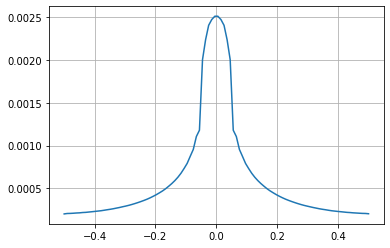

In [136]:
def check_float(textin):
    try:
        float(textin)
        return True

    except ValueError:
        return False

def check_force(folder):
    import os
    import numpy as np
    files = os.listdir(folder)
    cleaned = [int(x) for x in files if check_float(x)]
    if os.path.exists(folder+"/postProcessing/forces/{}".format(np.max(cleaned))):
        return False
    else:
        return True
    
def retrieve_lift(folder,debug=False):
    import os
    import shutil
    import numpy as np
    
    files = os.listdir(folder)
    cleaned = [x for x in files if check_float(x)]
    files = sorted(cleaned)
    needs_forces = check_force(folder)
    if debug:
        print(folder,needs_forces)
    if needs_forces:
        force_command = "rhoSimpleFoam -postProcess -case {} -func forces".format(folder)
        os.system(force_command)
    else:
        pass
    
    forces = np.zeros(3)
    moments = np.zeros(3)
    time = np.array([])
    
    for file in files:    
        with open("{}/postProcessing/forces/{}/forces.dat".format(folder,file)) as f:
            full = f.readlines()
            line = full[3]
            starts = []
            ends = []
            for i in range(len(line)):
                if line[i] == '(' and line[i+1] != '(':
                    starts.append(i+1)
                elif line[i] == ')' and line[i-1] != ')':
                    ends.append(i)
            pressure_forces = np.array([float(x) for x in line[starts[0]:ends[0]].split()])
            viscous_forces = np.array([float(x) for x in line[starts[1]:ends[1]].split()])

            pressure_moments = np.array([float(x) for x in line[starts[2]:ends[2]].split()])
            viscous_moments = np.array([float(x) for x in line[starts[3]:ends[3]].split()])
            forces = np.vstack([forces, pressure_forces + viscous_forces])
            moments = np.vstack([moments, pressure_moments + viscous_moments])
            time = np.append(time,float(file))
    return forces, moments, time    

def max_velocity(folder, debug=False):
    import os
    import shutil
    import numpy as np
    files = os.listdir(folder)
    cleaned = [float(x) for x in files if check_float(x)]
    filename = np.max(cleaned)
    if int(filename) == filename:
        filename = '{}/{}/U'.format(folder,int(filename))
    else:
        filename = '{}/{}/U'.format(folder,filename)
    with open(filename) as f:
        Utext = f.readlines()
    numlines = int(Utext[19])
    start = 21
    end = start+numlines-1
    Umax = 0
    for i in range(start,end):
        line = Utext[i][1:-2]
        vals = [float(x) for x in line.split()]
        Umag = np.sqrt(vals[0]**2 + vals[1]**2)
        if Umag > Umax:
            Umax = Umag
    return Umax

def max_velocity_ind(folder, index):
    import os
    import numpy as np
    files = os.listdir(folder)
    cleaned = [float(x) for x in files if check_float(x)]
    filename = np.max(cleaned)
    if int(filename) == filename:
        filename = '{}/{}/U'.format(folder,int(filename))
    else:
        filename = '{}/{}/U'.format(folder,filename)
    with open(filename) as f:
        Utext = f.readlines()
    line = Utext[index][1:-2]
    vals = [float(x) for x in line.split()]
    Umag = np.sqrt(vals[0]**2 + vals[1]**2)
    return Umag
    
        

def VTK_files(folder,debug=False):
    import os
    vtk_exists = os.path.exists(folder + '/VTK')
    if vtk_exists:
        if debug:
            print('VTK Exists for case: {}'.format(folder))
        pass
    else:
        os.system('foamToVTK -case {} -latestTime'.format(folder))
    for file in os.listdir(folder+'/VTK/'):
        if file[-3:] == 'vtk':
            target = file
        else:
            pass
    return target
    

def find_momentum_thickness(mesh,chord_length,position,Uinf):
    import numpy as np
    c = chord_length    
    p = position
    mesh.set_active_scalars('U')
    x = mesh.sample_over_line([-c+(c*p),0.00,0.078],[-c+(c*p),3.0,0.078])
    Udata = x.point_data['U']
    Umag = np.sqrt(Udata[:,0]**2+Udata[:,1]**2)
    dtheta = (Umag/Uinf)*(1-(Umag/Uinf))
    points = x.points
    y = points[:,1]
    bl = np.trapz(dtheta,x=y)
    return(bl)   

def find_displacement_thickness(mesh,chord_length,position,Uinf):    
    import numpy as np
    c = chord_length    
    p = position
    mesh.set_active_scalars('U')
    x = mesh.sample_over_line([-c+(c*p),0.00,0.078],[-c+(c*p),3.0,0.078])
    Udata = x.point_data['U']
    Umag = np.sqrt(Udata[:,0]**2+Udata[:,1]**2)
    ddelta = (1-(Umag/Uinf))
    points = x.points
    y = points[:,1]
    bl = np.trapz(ddelta,x=y)
    return(bl)   

# def find_profile(mesh,position):
#     import numpy as np
#     p = position
#     mesh.set_active_scalars('U')
#     x = mesh.sample_over_line([position, -4.8, 0.78],[position,4.8,0.78])
#     Udata = x.point_data['U']
#     Pdata = x.point_data('P')
#     return Udata,Pdata
    

def read_chord_length(folder,line_number = 28):
    with open(folder + '/system/blockMeshDict') as f:
        lines = f.readlines()
        chord_def_line = lines[line_number]
        ind = []
        for j in range(len(chord_def_line)):
            if chord_def_line[j] == '(':
                ind.append(j+1)
            elif chord_def_line[j] == ')':
                ind.append(j)
        numbers = chord_def_line[ind[0]:ind[1]].split(' ')
        cl = -float(numbers[0])
    return cl

def U_from_Re(re,chord):
    mu = 1.82e-5
    rho = 1.17
    U = re * mu / (rho * chord)
    return U

    
def find_profile(mesh,position,ylower,yupper):
    import numpy as np
    p = position
    mesh.set_active_scalars('U')
    x = mesh.sample_over_line([position, ylower, 0.],[position, yupper, 0.])
    Udata = x.point_data['U']
    mesh.set_active_scalars('p')
    y = mesh.sample_over_line([position, ylower, 0.],[position, yupper, 0.])
    Pdata = y.point_data['p']
    Tdata = y.point_data['T']
    y = y.points[:,1]
    return Udata,Pdata,Tdata,y

def read_massflow_rate(case='./'):
    with open(case+'/0/U','r') as f:
        lines = f.readlines()
        mdotupper = float(lines[23].split()[1][:-1])
        mdotlower = float(lines[24].split()[1][:-1])
    return mdotupper, mdotlower

def mdot_to_ujet(mdot):
    import numpy as np
    p = np.array([5.88499352e+07, -2.85890169e+05,  2.45334456e+04, -5.26886602e-02])
    Ujet = np.polyval(p,mdot)
    return Ujet

def slot_thrust(case='./',uplo = 1):
    import numpy as np
    import pyvista as pv
    R = 287
    targ_end = VTK_files(case).split('_')[-1]
    if uplo == 1:
        target = '{}/VTK/coandaUpper/coandaUpper_{}'.format(case,targ_end)
    elif uplo == -1:
        target = '{}/VTK/coandaLower/coandaLower_{}'.format(case,targ_end)
    mesh = pv.read(target)
    mesh.set_active_scalars('p')
    
    y = mesh.points
    inds = [i for i in range(len(y)) if y[i,2] > 0]
    
    w = np.max(y[:,2]) - np.min(y[:,2]) 
    h = np.max(y[:,1]) - np.min(y[:,1])
    A_slot = .1 * h
    U = mesh['U']
    P = mesh['p']
    T = mesh['T']
    y = y[inds,1]
    ycent = [(y[i+1] + y[i])/2 for i in range(len(y)-1)]
    v = U[:,0]
    rho = P / (R * T)
    thrust = np.mean(rho * v * v) * A_slot
    return thrust
    
def sectional_lift_coefficient(case='./',nz=100):
    import numpy as np
    import pyvista as pv
    from matplotlib import pyplot as plt
    targ_end = VTK_files(case).split('_')[-1]
    target = '{}/VTK/surface/surface_{}'.format(case,targ_end)
    
    mesh = pv.read(target)
    slices = mesh.slice_along_axis(n=20,axis='z')
    p = mesh.cell_data['p']
    nx = len(p)//nz
    x = mesh.points
    face_inds = mesh.faces
    face_inds = np.reshape(face_inds,[len(face_inds)//5,5])[:,1:]
    section_lift = np.zeros(nz)
    face_force = np.zeros([nx,nz,2])
    for j in range(nz):
        for i in range(nx):
            index = i*nz + j
            points = x[face_inds[index,:]]
            if points[1,2] == points[0,2]:
                dx = points[1,0] - points[0,0]
                dy = points[1,1] - points[0,1]
                dz = points[2,2] - points[1,2]
            else:
                dx = points[2,0] - points[1,0]
                dy = points[2,1] - points[1,1]
                dz = points[1,2] - points[0,2]
            area = (np.sqrt(dy**2 + dx**2)*np.abs(dz))
            n = np.array([-dy,dx])/np.sqrt(dy**2 + dx**2)
            face_force[i,j,:] = p[index] * area * -n
        section_lift[j] = np.sum(face_force[:,j,1])/(0.5*1.17*25**2*1*.3)
    return section_lift
import matplotlib.pyplot as plt
lift = sectional_lift_coefficient()
x = np.linspace(-0.5,0.5,100)
plt.plot(x,lift)
print(np.sum(lift))
plt.grid()

[20.56465974 28.01879375 34.83053812 40.33396837 44.9138544  48.70499371
 51.18508105]


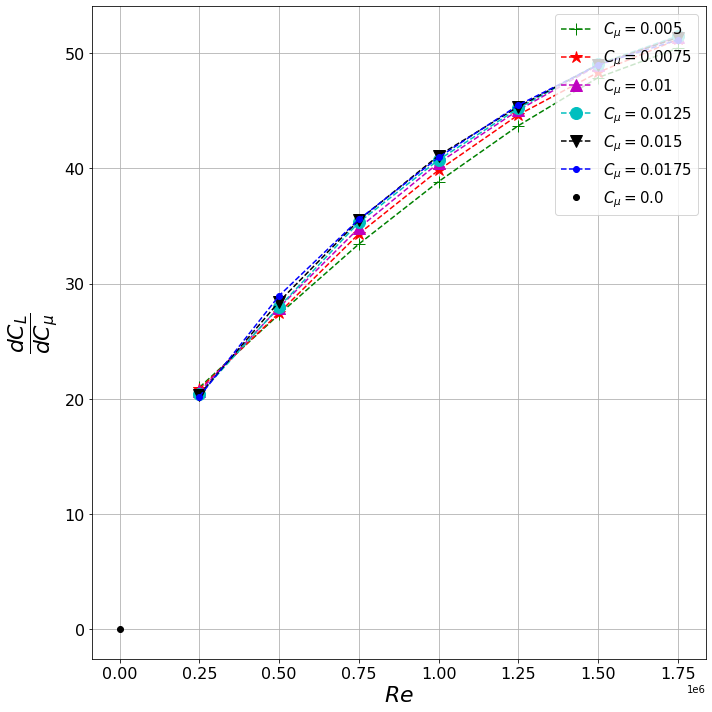

In [5]:
# Reynolds Number Dependence Investigation

import numpy as np
import os
from matplotlib import pyplot as plt

# folders = ['/home/james/Documents/research/completed_cases/reynolds_dependence/c0.3/','/home/james/Documents/research/completed_cases/reynolds_dependence/c0.5/','/home/james/Documents/research/completed_cases/reynolds_dependence/c1.0/']
kk=0
index = 1  # 0 CD, 1 CL
# folders = ['/home/james/Documents/research/completed_cases/reynolds_dependence/c1.5/','/home/james/Documents/research/completed_cases/reynolds_dependence/c0.6/']
# folders = ['/home/james/Documents/research/completed_cases/reynolds_dependence/c1.5/']
opt_folder = '/home/james/Documents/research/completed_cases/reynolds_dependence/opt/'
base_folder = '/home/james/Documents/research/completed_cases/reynolds_dependence/baseline/'
# base_folder = '/home/james/Documents/research/completed_cases/reynolds_dependence/sa/c0.5/'

folders = [base_folder]

rho = 1.17

# Processing for offsets on opt case
cmu0_dir = opt_folder + 'cmu0/'
cmu1_dir = base_folder+ 'cmu0/'
re_dirs = os.listdir(cmu0_dir)
n = len(re_dirs)
CL_off = []
re_off = []
for j in range(n):
    current = cmu0_dir + re_dirs[j]
    chord = read_chord_length(current)
    re = float(re_dirs[j][2:])
    U = U_from_Re(re,chord)
    forces, moments, time = retrieve_lift(current)
    re_off.append(re)
    CL_off.append(forces[-1, index] / (0.5 * rho * U**2 * chord * 0.156))

CL_off_base = []
re_off_base = []
for j in range(n):
    current = cmu1_dir + re_dirs[j]
    chord = read_chord_length(current)
    re = float(re_dirs[j][2:])
    U = U_from_Re(re,chord)
    forces, moments, time = retrieve_lift(current)
    re_off_base.append(re)
    CL_off_base.append(forces[-1, index] / (0.5 * rho * U**2 * chord * 0.156))
re_off = np.array(re_off)
sortoff = np.argsort(re_off)
CL_off = np.array([CL_off[i] for i in sortoff])
##############


    
re_off = np.array(re_off)
sortoff = np.argsort(re_off)
CL_off = np.array([CL_off[i] for i in sortoff])

CL_opt = np.zeros([7,6])
CL_base = np.zeros([7,6])
for folder in folders:
    plt.figure(figsize=[10,10])
    cmu_dirs = os.listdir(folder)
    m = len(cmu_dirs)
    rho = 1.17
    
    shape_by_cmu = ['bx--','g+--','r*--','m^--','co--','kv--','b.--','gd--','r>--','m<--']
    legend = []
    
    cmu_arr = []
    for i in range(m):
        cmu = float(cmu_dirs[i][3:])
        cmu_arr.append(cmu)
        
    
    sort_cmu = np.argsort(np.array(cmu_arr))
    cmu_arr = [cmu_arr[i] for i in sort_cmu]
    cmu_dirs = [cmu_dirs[i] for i in sort_cmu]
    for cmu in cmu_arr:
        legend.append(r'$C_\mu = {}$'.format(np.around(cmu,4)))
    cmus = []

    for i in range(len(cmu_dirs)):
        cmu = float(cmu_dirs[i][3:])
        cmus.append(cmu)
        if cmu == 0:
            continue
        re_dirs = os.listdir(folder + '/' + cmu_dirs[i] + '/')
        n = len(re_dirs)
        CL_arr = []
        dCL_arr = []
        re_arr = []
        for j in range(n):
            current_folder = folder + '/' + cmu_dirs[i] + '/' + re_dirs[j] + '/'
            re = float(re_dirs[j][2:])
            re_arr.append(re)
            chord = read_chord_length(current_folder)
            U = U_from_Re(re,chord)
            forces, moments, time = retrieve_lift(current_folder)
            
          
            CL_arr.append((forces[-1,index] / (0.5 * rho * U**2 * chord * 0.156))-cmu)
        
        sortinds = np.argsort(re_arr)
        re_arr = [re_arr[i] for i in sortinds]
        CL_arr = np.array([CL_arr[i] for i in sortinds])
        if folder[-4:-1] == 'opt':
            plt.plot(re_arr,(CL_arr-CL_off)/cmu,shape_by_cmu[i-1],label=legend[i],markersize=12)
            CL_opt[:,i-1] = (CL_arr-CL_off)/cmu
        else:
            CL_base[:,i-1] = CL_arr/cmu
            plt.plot(re_arr,(CL_arr-CL_off_base)/cmu,shape_by_cmu[i],label=legend[i],markersize=12)
     
        
    plt.plot([0],[0],'ko',label=r'$C_\mu = 0.0$')

    
    plt.legend(fontsize=15,loc="upper right")
    plt.xlabel(r'$Re$',fontsize=22)
    plt.ylabel(r'$\dfrac{dC_L}{dC_\mu}$',fontsize=22)
#     plt.ylabel(r'$\Delta C_D$',fontsize=22)
    plt.tick_params(labelsize=16)
#     plt.xlim([-.1e6,2.9e6])
    plt.grid()
    plt.tight_layout()
#     plt.title(r'$c = {}m$'.format(chord),fontsize = 16)
    kk+=1
#     plt.savefig('./output/pres/cfd_re_dep_dcd.png')

# stdopt = np.std(CL_opt,1)
# stdbase = np.std(CL_base,1)

# meanopt = np.mean(CL_opt,1)
meanbase = np.mean(CL_base,1)
print(meanbase)

# plt.figure(figsize=[10,10])
# plt.errorbar(re_arr,meanopt,2*stdopt,fmt='bo--',capsize=5,mfc='None')
# plt.errorbar(re_arr,meanbase,2*stdbase,fmt='rx--',capsize=5,mfc='None')
# plt.legend(['AFC Opt. Profile','NACA0015 Profile'],fontsize=15)
# plt.grid()
# plt.xlabel(r'$Re$',fontsize=18)
# plt.ylabel(r'$\dfrac{dC_L}{dC_\mu}$',fontsize=24)
# plt.tick_params(labelsize=20)
# plt.tight_layout()
# plt.savefig('./output/cfd_meandcl.png')

# shape_by_cmu_deltas = ['bx','g+','r*','m^','co','kv','b.','gd','r>']
# CL_diff = (CL_opt - CL_base) / CL_base
# plt.figure(figsize=[10,10])
# for i in range(len(cmus)):
#     plt.plot(re_arr,CL_diff[:,i]*100,shape_by_cmu_deltas[i],label=legend[i],markersize = 12)
# plt.legend(fontsize=15)
# plt.xlabel(r'$Re$', fontsize=16)
# plt.ylabel(r'% Increase of $\Delta C_L$', fontsize=16)
# plt.grid()
                     
# plt.savefig('./output/delta_cl_re_dependence_preliminary.png')

30642.54775402161


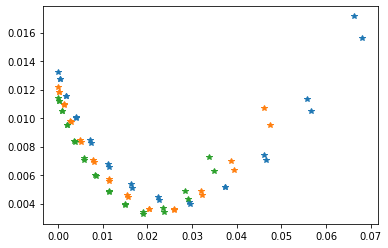

In [62]:
parent = '/home/james/Documents/research/completed_cases/coanda_airfoils/steady/NACA0015/multidir/'
velo = np.sort(os.listdir(parent))
N = len(velo)
Uinf = np.zeros(N)
c = 0.3
b = 0.156
test = []
for i in range(N):
    Uinf[i] = float(velo[i].split('m')[0])
    QS = 0.5 * 1.17 * Uinf[i]**2 * c * b
    vel_targ = parent + velo[i] + '/'
    mdotsf = os.listdir(vel_targ)
    M = len(mdotsf)
    mdots = np.zeros([M])
    if i == 0:
        l = np.zeros([N,M])
        d = np.zeros([N,M])
        my = np.zeros([N,M])
        
        dd = np.zeros([N,M])        
        dl = np.zeros([N,M])        
        dm = np.zeros([N,M])
        
        cmu = np.zeros([N,M])
    for j in range(M):
        target = parent + velo[i] + '/' + mdotsf[j] + '/'
        ff,mm,tt = retrieve_lift(target)
        mdot_str = mdotsf[j].split('k')[0]
        if mdot_str[0] == 'n':
            mdot = - float(mdot_str[1:])
        else:
            mdot = float(mdot_str)
        if mdot > 0.001:
            vjet = max_velocity(target)
            test.append(vjet/mdot)
        else:
            vjet = 31525 * mdot
        l[i,j] = ff[-1,1]/QS
        d[i,j] = (ff[-1,0]-mdot*vjet)/QS
        my[i,j] = mm[-1,2]/(QS*c)
        cmu[i,j] = mdot * vjet / QS
        if cmu[i,j] > 0:
            dl[i,j] = l[i,j]/cmu[i,j]
            dd[i,j] = d[i,j]/cmu[i,j]
            dm[i,j] = my[i,j]/cmu[i,j]
            
plt.figure()
for i in range(3,N):
    plt.plot(cmu[i,:],d[i,:],'*')
print(np.min(np.array(test)))

aoa: 2.0
-0.5917318929234998 0.0010789920000000564
aoa: 10.0
-0.5411946229235003 -0.5771065900000032
aoa: 0.0
-0.5867688229234997 0.048802344890999994
aoa: 4.0
-0.5903203229234998 -0.18869628000000027
aoa: 6.0
-0.5957061229234999 -0.26215322000000185
aoa: 12.0
-0.10507592292349965 -2.2856194999999992
aoa: 8.0
-0.5823777229234997 -0.43344590999999966
aoa: 14.0
1.7698002770765004 -7.303158239999998


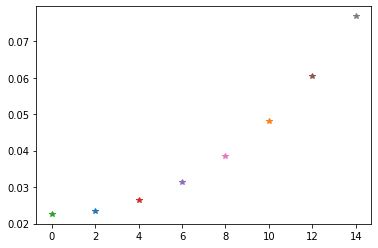

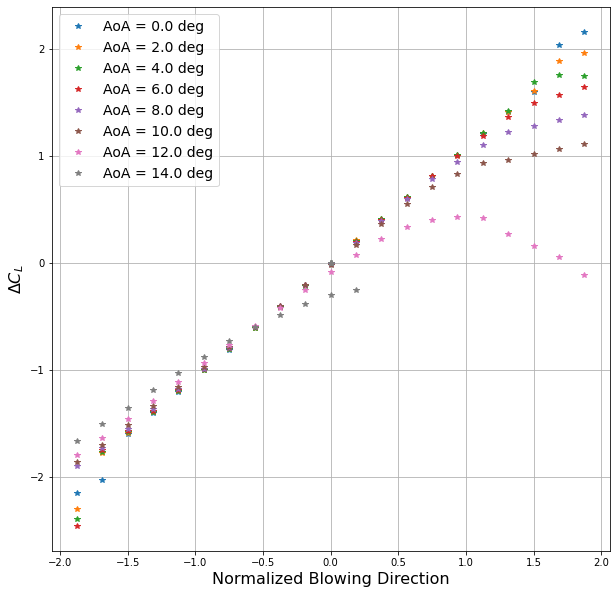

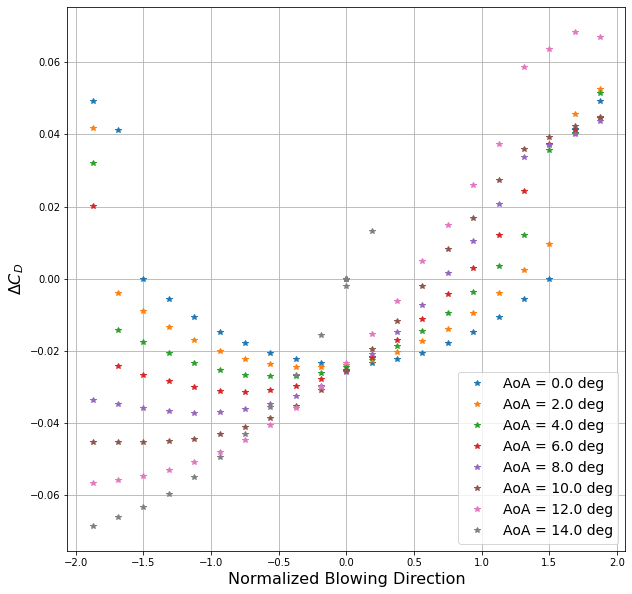

In [646]:
import numpy as np
from matplotlib import pyplot as plt
import os

data_folder = '/home/james/Documents/research/completed_cases/directional/'
aoas = os.listdir(data_folder)
aoa_arr = []
N = len(os.listdir(data_folder + aoas[0]))
M = len(aoas)

lift = np.zeros([M,N-1])
drag = np.zeros([M,N-1])
direction = np.zeros([M,N-1])
leg = []
baselift_arr = []
basedrag_arr = []
plt.figure()
for j in range(M):
    current = data_folder + aoas[j]    
    aoa = float(aoas[j][3:])
    aoa_arr.append(aoa)
    baseline = current + '/baseline/'
    forces, moments, _time = retrieve_lift(baseline)
    l = forces[-1,1]
    d = forces[-1,0]
    baselift = (l * np.cos(aoa*np.pi/180) - d * np.sin(aoa*np.pi/180))/ (0.5 * 1.17 * 30**2 *.156 * .3)
    basedrag = (d * np.cos(aoa*np.pi/180) + l * np.sin(aoa*np.pi/180)) / (0.5 * 1.17 * 30**2 *.156 * .3)
    baselift_arr.append(baselift)
    basedrag_arr.append(basedrag)
    targets = os.listdir(current)
    targets = [i for i in targets if i != 'baseline']
    plt.plot(aoa,basedrag,'*')
    leg.append('AoA = {} deg'.format(aoa))
    N = len(os.listdir(data_folder + aoas[j]))
    for i in range(N-1):
        target = current + '/' + targets[i]
        names = targets[i].split('_')
        upper = float(names[0][1:])
        lower = float(names[1][1:])
        direction[j,i] = (upper - lower) / 0.004
        forces, moments, _time = retrieve_lift(target)
        mdotu, mdotl = read_massflow_rate(target)
        Ujetu = mdot_to_ujet(mdotu)
        Ujetl = mdot_to_ujet(mdotl)
        T =  mdotu*Ujetu + mdotl*Ujetl
        li = forces[-1,1]
        di = forces[-1,0] - T
        
        lift[j,i] = (li * np.cos(aoa*np.pi/180) - di * np.sin(aoa*np.pi/180))/ (0.5 * 1.17 * 30**2 *.156 * .3) - baselift
        drag[j,i] = (di * np.cos(aoa*np.pi/180) + li * np.sin(aoa*np.pi/180)) / (0.5 * 1.17 * 30**2 *.156 * .3) - basedrag
        
        if mdotu == mdotl:
            print("aoa: {}".format(aoa))
            print(di-d,li-l)

aoa_arr = np.array(aoa_arr)
sort_ind = np.argsort(aoa_arr)

drag = np.array([drag[i,:] for i in sort_ind])
lift = np.array([lift[i,:] for i in sort_ind])
direction = np.array([direction[i,:] for i in sort_ind])
leg = [leg[i] for i in sort_ind]


plt.figure(figsize=[10,10])
sel = []
for i in range(M):
    plt.plot(direction[i,:],lift[i,:],'*')
    sel.append(leg[i])

plt.legend(sel,fontsize=14)
plt.ylabel(r'$\Delta C_L$',fontsize=16)
plt.xlabel(r'Normalized Blowing Direction',fontsize=16)
plt.grid()
plt.savefig('./output/CL_vs_dir_aoa.png')

sel = []
plt.figure(figsize=[10,10])
for i in range(M):
    sel.append(leg[i])
    plt.plot(direction[i,:],drag[i,:],'*')
plt.legend(sel,fontsize=14)
plt.ylabel(r'$\Delta C_D$',fontsize=16)
plt.xlabel(r'Normalized Blowing Direction',fontsize=16)
plt.grid()
plt.savefig('./output/CD_vs_dir_aoa.png')


[[ 0.          0.        ]
 [ 0.         -0.01626602]
 [ 0.14285714 -0.08888717]
 [ 0.28571429 -0.10953314]
 [ 0.42857143 -0.10775439]
 [ 0.57142857 -0.10597564]
 [ 0.71428571 -0.1041969 ]
 [ 0.85714286 -0.07168344]
 [ 1.          0.        ]]


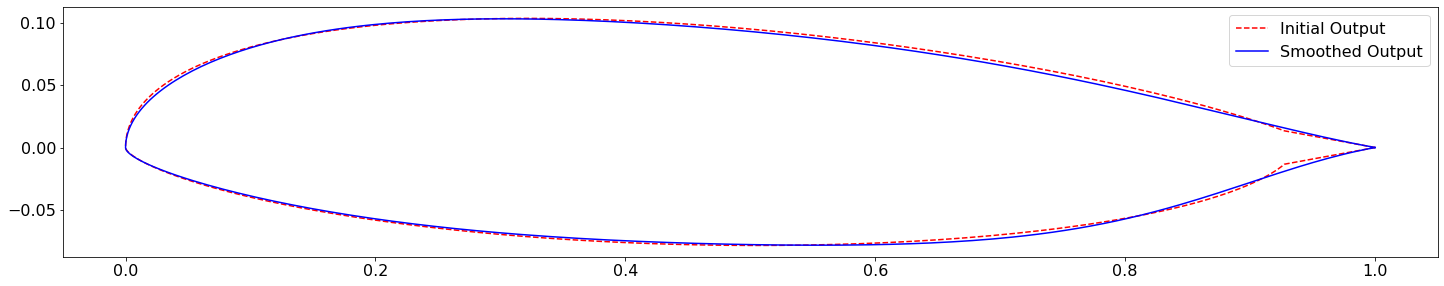

In [667]:
import numpy as np
from matplotlib import pyplot as plt
from bezier_foil import *
from scipy.interpolate import interp1d

airfoil_folder = '/home/james/Documents/research/cfd/airfoils/'
cp_folder = airfoil_folder + '/optimization/'
af_filename = airfoil_folder + '/opt_foil1.txt'

runname = 'opt_fd5'
sel = 927

cpu = np.loadtxt(cp_folder + '/' + runname + '/' + '{}_cpu.txt'.format(sel))
cpl = np.loadtxt(cp_folder + '/' + runname + '/' + '{}_cpl.txt'.format(sel))


zero = np.array([0,0])
cpu_init = np.vstack([cpu,inter_up,zero]) / 0.3 + (np.array([1,0]))
cpl_init = np.vstack([cpl,inter_lo,zero]) / 0.3 + (np.array([1,0]))

interp_upper = interp1d(cpu_init[:,0], cpu_init[:,1])
xcoords_upper = np.linspace(cpu_init[0,0],cpu_init[-1,0],8)
ycoords_upper = interp_upper(xcoords_upper)
cpu_init = np.vstack([xcoords_upper,ycoords_upper]).T

interp_lower = interp1d(cpl_init[:,0], cpl_init[:,1])
xcoords_lower = np.linspace(cpl_init[0,0],cpl_init[-1,0],8)
ycoords_lower = interp_lower(xcoords_lower)
cpl_init = np.vstack([xcoords_lower,ycoords_lower]).T

cpu_init = np.vstack([zero,cpu_init])
cpl_init = np.vstack([zero,cpl_init])
print(cpl_init)


curve_upper = bezier_curve(cpu,201)
curve_lower = bezier_curve(cpl,201)

points = np.vstack([zero,curve_upper[::-1,:],curve_lower,zero])
points = points / 0.3 + np.array([1,0])

cp_opt_up = np.loadtxt(airfoil_folder + '/control_points/opt2_cpu.txt')
cp_opt_lo = np.loadtxt(airfoil_folder + '/control_points/opt2_cpl.txt')

surf = init_bezfoil(201, cp_opt_up, control_points_lower=cp_opt_lo,symmetric=False)
surf = surf/0.3 + np.array([1,0])

plt.figure(figsize= [20,4])
plt.plot(points[:,0],points[:,1],'r--',surf[:,0],surf[:,1],'b-')
plt.legend(['Initial Output','Smoothed Output'],fontsize=16)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.tick_params(axis='both',labelsize=16)
plt.savefig('/home/james/Documents/research/thesis/opt_airfoil_comp.png')

# (control_points,af_filename,chord = 1., eps=1e-6, deps=1e-12, m=101, step=1, debug=False,control_points_lower=[],sym=True

# print(load_airfoil(af_filename))
# foil, cpu, cpl, _iter = foil_opt(cpu_init, af_filename, eps = 1e-6,step = 2, chord = 0.3, m = 201, debug = True, control_points_lower = cpl_init, sym=False)

[[-0.3         0.        ]
 [-0.3         0.0120011 ]
 [-0.28846734  0.0534197 ]
 [-0.08887444  0.02866668]
 [-0.0217735   0.00400585]] [[-0.3         0.        ]
 [-0.3        -0.00487981]
 [-0.24422538 -0.03323273]
 [-0.05413542 -0.03086587]
 [-0.0217735  -0.00400585]]


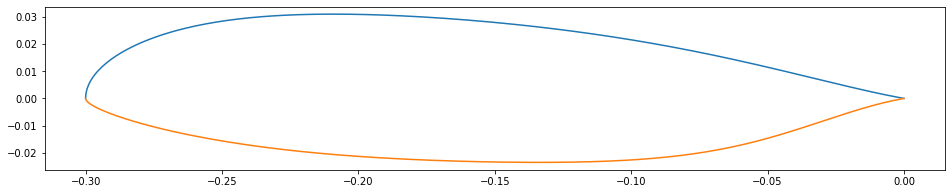

In [658]:
print(cpu,cpl)

cpu = np.loadtxt(airfoil_folder + '/control_points/' + 'opt2_cpu.txt')
cpl = np.loadtxt(airfoil_folder + '/control_points/' + 'opt2_cpl.txt')

up = bezier_curve(cpu,201)
lo = bezier_curve(cpl,201)

plt.figure(figsize=[20,3])
plt.plot(up[:,0],up[:,1],lo[:,0],lo[:,1])
plt.gca().set_aspect('equal')


[[  0.           0.        ]
 [  0.          -6.33123502]
 [ 48.54857068 -18.60575199]
 [111.69145515 -37.08313067]
 [145.59893566  -3.68441072]
 [228.37509451 -46.76462032]
 [234.6723238  -11.03569847]
 [300.           0.        ]]


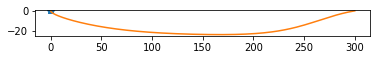

In [275]:
cpucsv = np.loadtxt(airfoil_folder + '/control_points/opt1_cpu.txt')
cplcsv = np.loadtxt(airfoil_folder + '/control_points/opt1_cpl.txt')

curvel = bezier_curve(cplcsv,201)
curvel = np.hstack([curvel,np.zeros([201,1])]) + (np.array([0.3,0,0]))
curvel = curvel * 1000

curveu = bezier_curve(cpucsv,201)
curveu = np.hstack([curveu,np.zeros([201,1])]) + (np.array([0.3,0,0]))
curveu = curveu * 1000



plt.plot(cplcsv[:,0],cplcsv[:,1],'*',curvel[:,0],curvel[:,1])
plt.gca().set_aspect('equal')
print((cplcsv+[0.3,0])*1000)

np.savetxt('./output/lower_opt.csv',curvel,delimiter=',')
np.savetxt('./output/upper_opt.csv',curveu,delimiter=',')

<IPython.core.display.Javascript object>


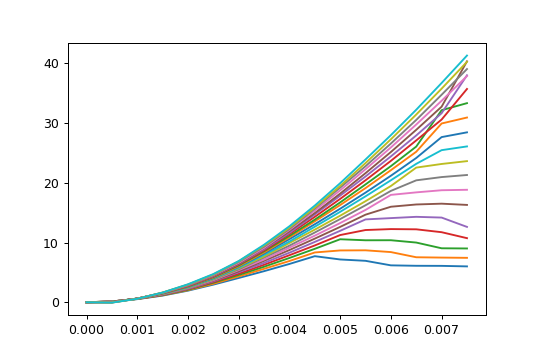

<IPython.core.display.Javascript object>


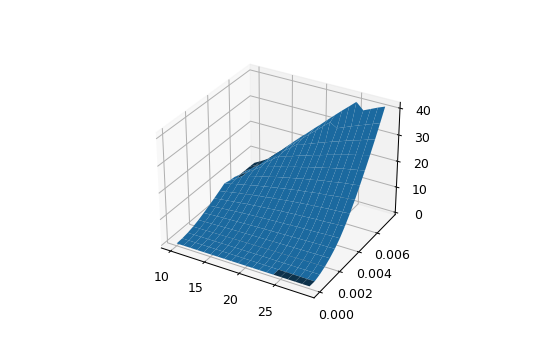

<IPython.core.display.Javascript object>


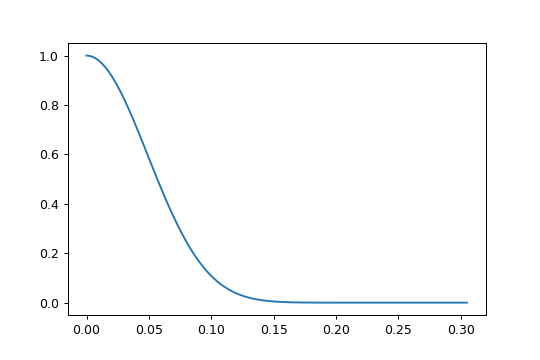

<IPython.core.display.Javascript object>


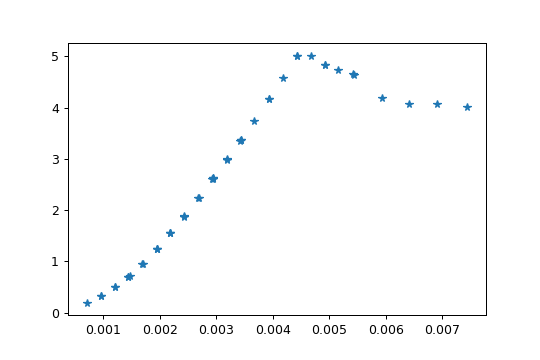

<IPython.core.display.Javascript object>


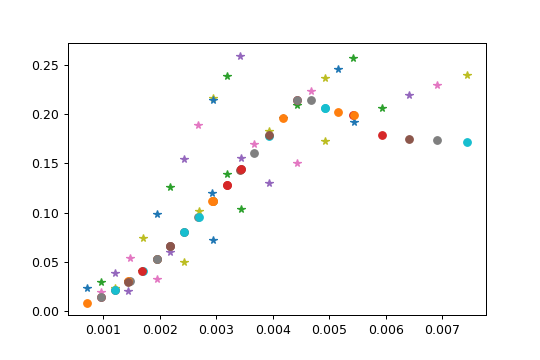

0.007213578525104016
0.01327742991281133


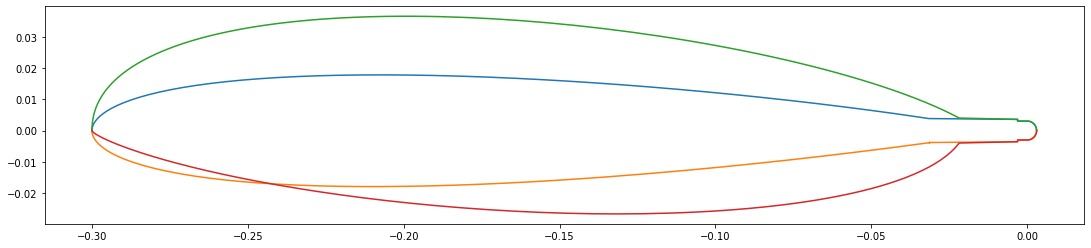

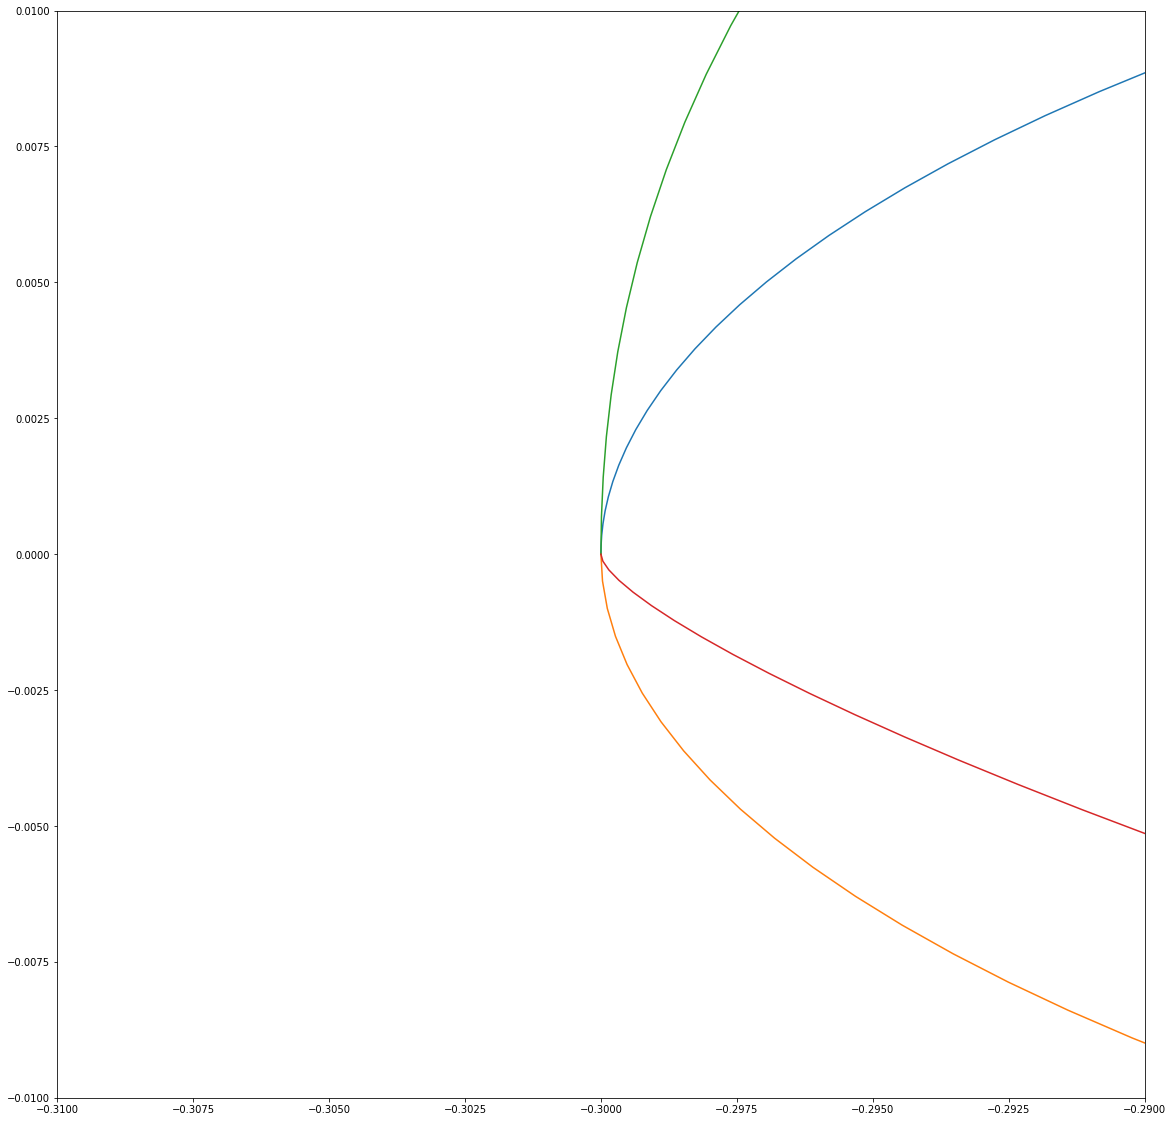

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from processing import *
from bezier_foil import *


pointsdir = '/home/james/Documents/research/cfd/airfoils/optimization/opt_fd4/'


def coanda_plot(cpu,cpl):
    R = 0.12 *  0.0254
    t = 0.012* 0.0254
    h = 0.009 * 0.0254
    x = np.linspace(0,np.pi/2,25)[::-1]
    
    cyl_up = np.zeros([25,2])
    for i in range(25):
        cyl_up[i,0] = R*np.cos(x[i])
        cyl_up[i,1] = R*np.sin(x[i])
    pts_up = np.array([cpu[-1,:],[-R,R+t+h],[-R,R+h],[-R,R]])
    pts_up = np.vstack([pts_up,cyl_up])
    pts_lo = np.array([1,-1]) * pts_up
    return pts_up,pts_lo
    
def curves_for_plot(cpu,cpl):
    import numpy as np
    co_up, co_lo = coanda_plot(cpu,cpl)
    bez_up = bezier_curve(cpu,101)
    bez_lo = bezier_curve(cpl,101)

    upper = np.vstack([bez_up,co_up])
    lower = np.vstack([bez_lo,co_lo])
    
    return upper, lower
prev_up = np.zeros([101+4+25,2])
prev_lo = np.zeros([101+4+25,2])
plt.figure(figsize=[20,4])
for k in [0,1300]:
    cpu = np.loadtxt(pointsdir+'{}_cpu.txt'.format(k))
    cpl = np.loadtxt(pointsdir+'{}_cpl.txt'.format(k))
    upper, lower = curves_for_plot(cpu,cpl)
    plt.plot(upper[:,0],upper[:,1],lower[:,0],lower[:,1])
    prev_up = upper
    prev_lo = lower

    plt.gca().set_aspect('equal')

    
plt.figure(figsize=[20,20])
for k in [0,1300]:
    cpu = np.loadtxt(pointsdir+'{}_cpu.txt'.format(k))
    cpl = np.loadtxt(pointsdir+'{}_cpl.txt'.format(k))
    upper, lower = curves_for_plot(cpu,cpl)
    plt.plot(upper[:,0],upper[:,1],lower[:,0],lower[:,1])
    prev_up = upper
    prev_lo = lower
    plt.xlim([-.31,-.29])
    plt.ylim([-.01,.01])
    plt.gca().set_aspect('equal')

    print(volume_calculation(cpu,cpl))

In [ ]:

legend = []
Re = np.array([])
plt.figure()
for i in range(len(flowspeedd)):
    Re = np.append(Re,1.17*float(flowspeedd[i])*0.3/1.82e-5)
    k = int(break_index[i])
    plt.plot(cmud[1:k,i], clsd[1:k,i]/cmud[1:k,i])
    plt.ylim([0,40])
    legend.append('Re = {}'.format(np.around(Re[i],-3)))
plt.legend(legend)

plt.figure(figsize=[10,10])
for i in range(len(flowspeedd)):
    k = int(break_index[i])
    plt.plot(theta[1:k,i] - theta[0,i],clsd[1:k,i])
    legend.append('Re = {}'.format(np.around(Re[i],-3)))
plt.xlabel(r'Change in Momentum Thickness $\Delta \Theta$')
plt.ylabel(r'$\Delta C_L$')
plt.title('Lift Coefficient vs. Momentum Thickness')
plt.legend(legend)
plt.savefig('/home/james/Documents/research/figures/coanda_boundary_layers/momentum_thickness_vs_CL.jpg')

plt.figure(figsize=[10,10])
for i in range(len(flowspeedd)):
    k = int(break_index[i])
    plt.plot(blsd[1:k,i] - blsd[0,i],clsd[1:k,i])
    legend.append('Re = {}'.format(np.around(Re[i],-3)))
plt.ylabel(r'$\Delta C_L$')
plt.xlabel(r'Change in Displacement Thickness $\Delta \delta_1$')
plt.title('Lift Coefficient vs. Displacement Thickness')
plt.legend(legend)
plt.savefig('/home/james/Documents/research/figures/coanda_boundary_layers/displacement_thickness_vs_CL.jpg')

print(cmud[0,:])
print(blsd[0,:])

plt.figure()
plt.plot(Re,blsd[0,:])

[[0.         0.00099431 0.00397724 0.00894879 0.01542044 0.02411887
  0.03477978 0.04742009 0.06205368 0.07870344 0.09739602 0.11816646]
 [0.         0.0005593  0.0022372  0.00503369 0.00867581 0.01357148
  0.0195737  0.02669244 0.03494016 0.04432796 0.054874   0.06659187]
 [0.         0.00035795 0.00143181 0.00322156 0.00555361 0.00868897
  0.01253386 0.0170957  0.02238194 0.02840316 0.03516859 0.0426903 ]]


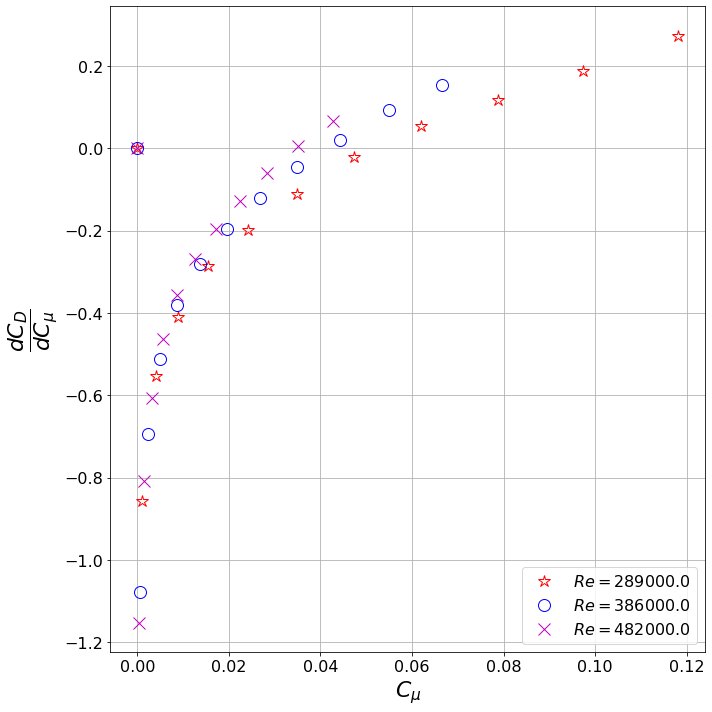

In [175]:
import numpy as np
from matplotlib import pyplot as plt
import os

us = [15,20,25]
mdots = np.arange(0,0.006,0.0005)
base = '/home/james/Documents/research/completed_cases/downward'

N = len(us)
M = len(mdots)
cl = np.zeros([N,M])
cd = np.zeros([N,M])
cm = np.zeros([N,M])

dcl = np.zeros([N,M])
dcd = np.zeros([N,M])
dcm = np.zeros([N,M])

cmu = np.zeros([N,M])

c = 0.3
b = 0.156
rho = 1.17
shapes = ['r*','bo','mx']
leg = []
for u in us:
    Re = np.around(u*rho*c/1.82e-5,-3)
    leg.append(r'$Re = {}$'.format(Re))
        

for i in range(N):
    for j in range(M):
        QS = 0.5 * rho * us[i]**2 * c * b
        mdot = np.around(mdots[j],4)
        target = base + '/{}kgps_{}mps'.format(mdot,us[i])
        if mdot > 0.0015:
            vjet = max_velocity(target)
        else:
            vjet = 24500 * mdot
        ff,mm,tt = retrieve_lift(target)
        cl[i,j] = ff[-1,1]/QS - cl[i,0]
        cd[i,j] = (ff[-1,0]-mdot*vjet)/QS - cd[i,0]
        cm[i,j] = (mm[-1,2] + ff[-1,1]*0.225)/(QS*c)
        cmu[i,j] = mdot * vjet / QS
        if cmu[i,j] != 0:
            dcl[i,j] = cl[i,j]/cmu[i,j]
            dcd[i,j] = cd[i,j]/cmu[i,j]
            dcm[i,j] = cm[i,j]/cmu[i,j]
plt.figure(figsize=[10,10])

lab = [r'$\Delta C_D$',r'$\Delta C_L$',r'$\Delta C_m$']
dlab = [r'$\dfrac{dC_D}{dC_\mu}$',r'$\dfrac{dC_L}{dC_\mu}$',r'$\dfrac{dC_m}{dC_\mu}$']

names = ['cdcmu.png','clcmu.png','cmcmu.png']
dnames = ['dcdcmu.png','dclcmu.png','dcmcmu.png']

for j in range(3):
    cd[j,0] = 0
    dcd[j,0] = 0

sel1 = 0
sel2 = 1


if sel2 == 0:
    label = lab[sel1]
    name = names[sel1]
    if sel1 == 0:
        loc = 'upper right'
        data = cd
    elif sel1 == 1:
        data = cl
        loc = 'upper left'
    elif sel1 == 2:
        data = cm
        loc = 'upper left'
else:
    label = dlab[sel1]
    name = dnames[sel1]
    if sel1 == 0:
        data = dcd
        loc = 'lower right'
    elif sel1 == 1:
        data = dcl
        loc = 'upper right'
    elif sel1 == 2:
        data = dcm
        loc = 'upper right'

for i in range(3):
    plt.plot(cmu[i,:],data[i,:],shapes[i],markersize=12,mfc='None')
plt.legend(leg,loc=loc,fontsize=16)
plt.grid()
plt.ylabel(label,fontsize=22)
plt.xlabel(r'$C_\mu$',fontsize=22)
plt.tick_params(labelsize=16)
plt.tight_layout()
print(cmu)
plt.savefig('./output/pres/'+name)

[[0.         0.00097605 0.00390419 0.00878443 0.01782131 0.02746452
  0.03915269]
 [0.         0.00054903 0.00219611 0.00494124 0.00999705 0.01541797
  0.02199111]
 [0.         0.00035138 0.00140551 0.00316239 0.00637874 0.00984622
  0.01405269]]
[[0.         0.00097605 0.00390419 0.00878443 0.01782131 0.02746452
  0.03915269]
 [0.         0.00054903 0.00219611 0.00494124 0.00999705 0.01541797
  0.02199111]
 [0.         0.00035138 0.00140551 0.00316239 0.00637874 0.00984622
  0.01405269]]


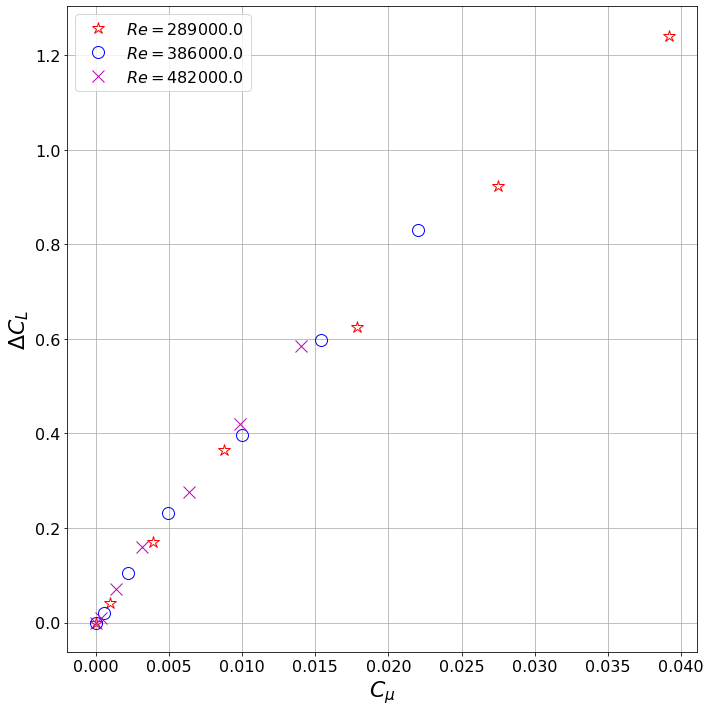

In [184]:
import numpy as np
from matplotlib import pyplot as plt
from processing import *
import pyvista as pv


us = [15,20,25]
mdots = np.arange(0,0.0031,0.0005)
N = len(us)
M = len(mdots)
base = '/home/james/Documents/research/completed_cases/steady_redo'

N = len(us)
M = len(mdots)
cl = np.zeros([N,M])
cd = np.zeros([N,M])
cm = np.zeros([N,M])

dcl = np.zeros([N,M])
dcd = np.zeros([N,M])
dcm = np.zeros([N,M])
cmu = np.zeros([N,M])
for i in range(N):
    for j in range(M):
        mdot = np.around(mdots[j],4)
        u = us[i]
        
        QS = 0.5 * rho * u**2 * c * b
        mdot = np.around(mdots[j],4)

        target = base + '/u_{}/mdot_{}/'.format(u,mdot)
        ff, mm, tt = retrieve_lift(target)
        if mdot > 0.0015:
            vjet = max_velocity(target)
        else:
            vjet = 24050 * mdot
        
        cl[i,j] = ff[-1,1]/QS - cl[i,0]
        cd[i,j] = (ff[-1,0]-mdot*vjet)/QS - cd[i,0]
        cm[i,j] = (mm[-1,2] + ff[-1,1]*0.225)/(QS*c)
        cmu[i,j] = mdot * vjet / QS
        if cmu[i,j] != 0:
            dcl[i,j] = cl[i,j]/cmu[i,j]
            dcd[i,j] = cd[i,j]/cmu[i,j]
            dcm[i,j] = cm[i,j]/cmu[i,j]

    

plt.figure(figsize=[10,10])

lab = [r'$\Delta C_D$',r'$\Delta C_L$',r'$\Delta C_m$']
dlab = [r'$\dfrac{dC_D}{dC_\mu}$',r'$\dfrac{dC_L}{dC_\mu}$',r'$\dfrac{dC_m}{dC_\mu}$']

names = ['cdcmu.png','clcmu.png','cmcmu.png']
dnames = ['dcdcmu.png','dclcmu.png','dcmcmu.png']

for j in range(3):
    cd[j,0] = 0
    dcd[j,0] = 0

sel1 = 1
sel2 = 0

if sel2 == 0:
    label = lab[sel1]
    name = names[sel1]
    if sel1 == 0:
        loc = 'upper right'
        data = cd
    elif sel1 == 1:
        data = cl
        loc = 'upper left'
    elif sel1 == 2:
        data = cm
        loc = 'upper left'
else:
    label = dlab[sel1]
    name = dnames[sel1]
    if sel1 == 0:
        data = dcd
        loc = 'lower right'
    elif sel1 == 1:
        data = dcl
        loc = 'upper right'
    elif sel1 == 2:
        data = dcm
        loc = 'upper right'
print(cmu)
for i in range(3):
    plt.plot(cmu[i,:],data[i,:],shapes[i],markersize=12,mfc='None')
plt.legend(leg,loc=loc,fontsize=16)
plt.grid()
plt.ylabel(label,fontsize=22)
plt.xlabel(r'$C_\mu$',fontsize=22)
plt.tick_params(labelsize=16)
plt.tight_layout()
print(cmu)
# plt.savefig('./output/pres/'+name)